In [47]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [48]:
SOS_token = 0
EOS_token = 1


In [49]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [50]:
def normalizeString(s):
    s = s.lower().strip()
    s = "".join(
        char
        for char in unicodedata.normalize("NFD", s)
        if unicodedata.category(char) != "Mn"
    )

    s = re.sub(r"([.f!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [51]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = (
        open("datasets/data/%s-%s.txt" % (lang1, lang2), encoding="utf-8")
        .read()
        .strip()
        .split("\n")
    )
    pairs = [[normalizeString(s) for s in l.split("\t")] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs


In [52]:
MAX_LENGTH = 10


In [53]:
eng_prefixes = (
    "i am ",
    "i m ",
    "he is",
    "he s ",
    "she is",
    "she s ",
    "you are",
    "you re ",
    "we are",
    "we re ",
    "they are",
    "they re ",
)


In [54]:
def filterPairs(pairs):
    return [
        p
        for p in pairs
        if len(p[0].split(" ")) < MAX_LENGTH
        and len(p[1].split(" ")) < MAX_LENGTH
        and p[1].startswith(eng_prefixes)
    ]


In [55]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang, output_lang.n_words)
    return input_lang, output_lang, pairs


In [56]:
input_lang, output_lang, pairs = prepareData("eng", "deu", reverse=True)
print(random.choice(pairs))


Reading lines...
Read 176692 sentence pairs
Trimmed to 9215 sentence pairs
Counted words:
deu 4280
<__main__.Lang object at 0x000001BA0051C1C0> 2800
['du vergleichst ap fel mit birnen !', 'you re comparing apples and oranges !']


In [57]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)


In [58]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)


In [59]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(" ")]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


In [60]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [61]:
teacher_forcing_ratio = 0.5


In [62]:
def train(
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [63]:
plot_losses = []
print_loss_total = 0
plot_loss_total = 0


In [64]:
hidden_size = 256


In [65]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)


In [66]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.01)
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(30000)]
criterion = nn.NLLLoss()


iteration - 1000 loss - 35.9550
iteration - 2000 loss - 31.3074
iteration - 3000 loss - 29.3779
iteration - 4000 loss - 28.3662
iteration - 5000 loss - 27.8669
iteration - 6000 loss - 27.2927
iteration - 7000 loss - 25.8391
iteration - 8000 loss - 25.3429
iteration - 9000 loss - 24.1142
iteration - 10000 loss - 23.4755
iteration - 11000 loss - 23.8879
iteration - 12000 loss - 22.5177
iteration - 13000 loss - 21.6314
iteration - 14000 loss - 21.2462
iteration - 15000 loss - 20.7922
iteration - 16000 loss - 20.5327
iteration - 17000 loss - 19.1406
iteration - 18000 loss - 19.1390
iteration - 19000 loss - 18.2683
iteration - 20000 loss - 17.8231
iteration - 21000 loss - 17.5370
iteration - 22000 loss - 17.2075
iteration - 23000 loss - 16.7326
iteration - 24000 loss - 16.1136
iteration - 25000 loss - 15.3888
iteration - 26000 loss - 15.6886
iteration - 27000 loss - 14.4009
iteration - 28000 loss - 14.4655
iteration - 29000 loss - 14.3121
iteration - 30000 loss - 14.1584


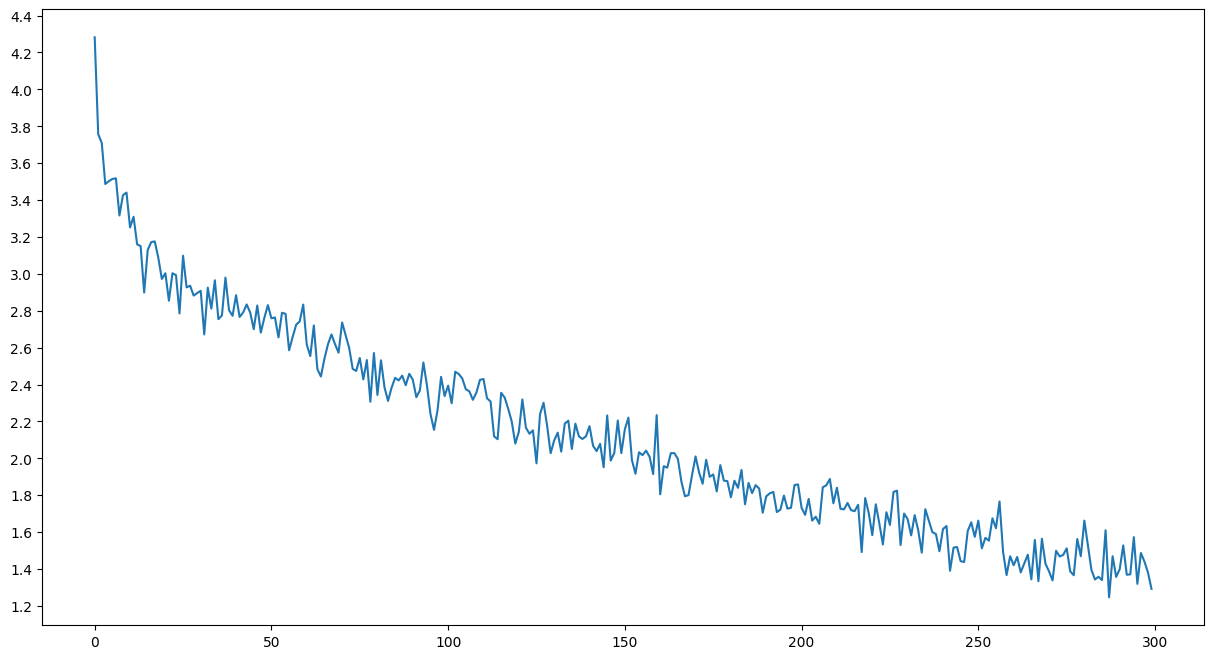

In [67]:
for iter in range(1, 30001):
    
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, 
                 encoder1, decoder1, 
                 encoder_optimizer, decoder_optimizer, 
                 criterion)
    
    print_loss_total += loss
    plot_loss_total += loss

    if iter % 1000 == 0:
        print_loss_avg = print_loss_total / 100
        print_loss_total = 0
        print('iteration - %d loss - %.4f' % (iter, print_loss_avg))

    if iter % 100 == 0:
        plot_loss_avg = plot_loss_total / 100
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

fig, ax = plt.subplots(figsize=(15, 8))
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

In [68]:
def evaluate(encoder, decoder, sentence):
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]])  
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, 
                                                     decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
                
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [69]:
for i in range(10):
        
        pair = random.choice(pairs)
        
        print('>', pair[0])
        print('=', pair[1])
        
        output_words = evaluate(encoder1, decoder1, pair[0])
        output_sentence = ' '.join(output_words)
        
        print('<', output_sentence)
        print('')

> ich bin nicht mehr dein mann .
= i m not your husband anymore .
< i m not your anymore anymore . <EOS>

> wir beschutzen dich .
= we re protecting you .
< we re coming you . <EOS>

> wir sind hier fertig .
= we re finished here .
< we re here to have . <EOS>

> sie spart geld um ins ausland zu gehen .
= she is saving money to go abroad .
< she is going to go to . . <EOS>

> er ist ein kluger junge .
= he s a smart boy .
< he s a smart boy . <EOS>

> du lugst mich an .
= you are lying to me .
< you re watching me . <EOS>

> er furchtet sich vor dem tod nicht .
= he isn t a fraid o f death .
< he isn t a fraid o f death . <EOS>

> es tut uns sehr leid .
= we re very sorry .
< we re very sorry . <EOS>

> ich bin nicht ubergewichtig .
= i m not obese .
< i m not a . <EOS>

> ich bin eine pro fessorin .
= i am a pro fessor .
< i am a prisoner . <EOS>



In [70]:
input_sentence = 'es tut mir sehr leid' #Re-run for 'es geht mir gut'

In [71]:
output_words = evaluate(encoder1, 
                        decoder1, 
                        input_sentence)

In [72]:
print('input =', input_sentence)
print('output =', ' '.join(output_words))

input = es tut mir sehr leid
output = i m very sorry . <EOS>
